In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from geopy.geocoders import Nominatim
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import contextily as ctx

In [2]:
competition = pd.read_csv("COMPETITION.csv")
demographics = pd.read_csv("DEMOGRAPHICS.csv")
potential_sites = pd.read_csv("POTENTIAL_SITES.csv")
stores = pd.read_csv("STORES.csv")

### Functions

In [3]:
def competition_lat_lon(string):
    """
    Convert a string in the format of "LAT:34.093416,LON:-117.688402" into separate latitude and longitude values

    Args:
        string (str): String formatted like "LAT:34.093416,LON:-117.688402".

    Returns:
        latitude: Latitude in the string after "LAT:".
        longitude: Longitude in the string after "LON:".
    """
    # find where latitude and longitude start in the string
    lat_index = string.find("LAT:") + 4
    lon_index = string.find("LON:") + 4
    
    if lat_index != -1 and lon_index != -1:
        lat_end_index = string.find(",", lat_index)
        lon_end_index = len(string)
        
        # latitude value equals string between the end of "LAT:" and start of "LON:"
        if lat_end_index != -1:
            latitude = float(string[lat_index:lat_end_index])
        
        # longitude value equals string between the end of "LON:" and end of the string
        if lon_end_index != -1:
            longitude = float(string[lon_index:lon_end_index])
    
    return latitude, longitude

In [4]:
def autozone_lat_lon(string):
    """
    Convert a string in the format of 12.123,45.456 into separate latitude and longitude values

    Args:
        string (str): String formatted like "12.123,45.456".

    Returns:
        latitude: Latitude in the string before the comma.
        longitude: Longitude in the string after the comma.
    """
    # split string into two coordinates by comma
    coordinates = string.split(",")
    
    # first coordinate equals the longitude, second coordinate equals longitude
    if len(coordinates) == 2:
        latitude = float(coordinates[0])
        longitude = float(coordinates[1])
    
    return latitude, longitude

In [5]:
def get_matching_records(df1, df2, column1, column2):
    """
    Check if values in two columns of a DataFrame exist in another DataFrame and return the matching records.

    Args:
        df1 (pandas.DataFrame): First DataFrame to compare.
        df2 (pandas.DataFrame): Second DataFrame to search in.
        column1 (str): Name of the first column to check.
        column2 (str): Name of the second column to check.

    Returns:
        pandas.DataFrame: DataFrame containing the matching records.
    """
    # return the records where both values are in both dataframes
    matching_records = df1[df1[column1].isin(df2[column1]) & df1[column2].isin(df2[column2])]

    return matching_records

In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two latitude/longitude pairs using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first point.
        lon1 (float): Longitude of the first point.
        lat2 (float): Latitude of the second point.
        lon2 (float): Longitude of the second point.

    Returns:
        float: Distance between the two points in miles.
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Radius of the Earth in kilometers and miles
    earth_radius_km = 6371.0
    earth_radius_mi = 3958.8

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_mi = distance_km * 0.62137119

    return distance_mi

In [7]:
def get_city_state(lat, lon):
    """
    Get the city and state information for a given latitude/longitude pair using Nominatim from OpenStreetMap.

    Args:
        lat (float): Latitude.
        lon (float): Longitude.

    Returns:
        tuple: A tuple containing the city and state information.
    """
    # feed latitude and longitude values into openstreetmap
    # reverse search to obtain a physical location
    geolocator = Nominatim(user_agent='my_app')
    location = geolocator.reverse(f'{lat}, {lon}', exactly_one=True)
    address = location.raw['address']
    # extract city and address values from location dictionary
    city = address.get('city', '') or address.get('town', '') or address.get('village', '')
    state = address.get('state', '')

    return city, state

In [166]:
def merge_dataframes(df1, df2, on_columns):
    """
    Merge two dataframes based on the "city" and "state" columns and include columns from df2 after "disToComp".

    Args:
        df1 (pandas.DataFrame): First dataframe.
        df2 (pandas.DataFrame): Second dataframe.
        on_columns (list): List of column names to merge on ("city" and "state" in this case).

    Returns:
        pandas.DataFrame: Merged dataframe.
    """
    # Find index for "disToComp" column in the second dataframe
    df2_columns = list(df2.columns)
    dis_to_comp_index = df2_columns.index("disToComp")
    columns_to_merge = df2_columns[dis_to_comp_index+1:]
    
    # Merge dataframe 1 with a subset of dataframe 2 using a left join
    # Subset columns are the columns needed for merging and all columns after "disToComp"
    merged_df = pd.merge(df1, df2[on_columns + columns_to_merge], on=on_columns, how="left")

    # Drop duplicate rows, keeping only the first match per row
    merged_df = merged_df.drop_duplicates(subset=df1.columns, keep="first")

    return merged_df

In [172]:
def left_join(df1, df2, on_columns):
    """
    Perform a left join operation on two dataframes based on the specified columns,
    including columns from df2 that appear after "disToComp", and return only the first match.

    Args:
        df1 (pandas.DataFrame): First dataframe.
        df2 (pandas.DataFrame): Second dataframe.
        on_columns (list): List of column names to join on.

    Returns:
        pandas.DataFrame: Left joined dataframe with only the first match.
    """
    # Find index for "disToComp" column in the second dataframe
    df2_columns = list(df2.columns)
    dis_to_comp_index = df2_columns.index("disToComp")
    columns_to_merge = df2_columns[dis_to_comp_index + 1:]

    # Remove "disToComp" from the columns to merge
    columns_to_merge = [column for column in columns_to_merge if column != "disToComp"]

    # Perform left join on specified columns
    merged_df = df1.merge(df2[on_columns + columns_to_merge], on=on_columns, how='left')

    # Drop duplicate rows, keeping only the first match per row
    merged_df = merged_df.drop_duplicates(subset=df1.columns)

    return merged_df

In [9]:
def calculate_disToNextAZ(df):
    """
    Calculate the shortest distance to a different Autozone store for each store in a dataframe.

    Args:
        df1 (pandas.DataFrame): Dataframe with lat/lon values.

    Returns:
        pandas.DataFrame: Same dataframe as input with new 'disToNextAZ' column.
    """
    
    # Initialize the new column disToNextAZ
    df['disToNextAZ'] = 0
    for i in range(len(df)):
        # Initialize a high value for our minimum distance
        minimum_distance = 1000000000
        # Iterate through df again to get distance between each other
        for j in range(len(df)):
            # Skip calculating the distance between the store and itself
            if i == j:
                pass
            else:
                # Assign lat1/lon1 pairing as coordinates of store in question from first loop
                # Assign lat2/lon2 pairing as coordinates of store to be compared to
                lat1, lon1 = df['latitude'][i], df['longitude'][i]
                lat2, lon2 = df['latitude'][j], df['longitude'][j]
                # Use calculate_distance function to calculate distance between the two stores
                distance = abs(calculate_distance(lat1, lon1, lat2, lon2))
                # If distance is less than our current minimum, overwrite it
                if distance < minimum_distance:
                    minimum_distance = distance
                else:
                    pass
        # Set disToNextAZ as the minumum value after completing the inner loop
        df.at[i, 'disToNextAZ'] = minimum_distance
    return df

In [10]:
def calculate_disToComp(df1, df2):
    """
    Calculate the shortest distance to a competitor's store from each Autozone store in the first DataFrame.

    Args:
        df1 (pandas.DataFrame): Dataframe of Autozone store locations with lat/lon values.
        df2 (pandas.DataFrame): Dataframe of competitor store locations with lat/lon values.

    Returns:
        pandas.DataFrame: df1 with new 'disToComp' column.
    """
    
    # Initialize the new column disToComp
    df1['disToComp'] = 0
    for i in range(len(df1)):
        # Initialize a high value for our minimum distance
        minimum_distance = 1000000000
        for j in range(len(df2)):
            # Assign lat1/lon1 pairing as coordinates of the Autozone store in question from first loop
            # Assign lat2/lon2 pairing as coordinates of the competitor's store to be compared to
            lat1, lon1 = df1['latitude'][i], df1['longitude'][i]
            lat2, lon2 = df2['latitude'][j], df2['longitude'][j]
            # Use calculate_distance function to calculate distance between the two stores
            distance = abs(calculate_distance(lat1, lon1, lat2, lon2))
            # If distance is less than our current minimum, overwrite it
            if distance < minimum_distance:
                minimum_distance = distance
            else:
                pass
        # Set disToComp as the minumum value after completing the inner loop
        df1.at[i, 'disToComp'] = minimum_distance
    return df1

In [183]:
def find_closest_lat_lon(df1, df2, lat_column, lon_column):
    """
    Find the closest lat/lon pair from df1 in df2 and merge all columns from df2 after "disToComp" onto df1.

    Args:
        df1 (pandas.DataFrame): First dataframe.
        df2 (pandas.DataFrame): Second dataframe.
        lat_column (str): Name of the latitude column.
        lon_column (str): Name of the longitude column.

    Returns:
        pandas.DataFrame: Merged dataframe containing all columns from df2 after "disToComp" for the closest lat/lon pair in df2 for each row in df1.
    """
    # Extract lat/lon values from both dataframes
    lat_lon_df1 = df1[[lat_column, lon_column]].values
    lat_lon_df2 = df2[[lat_column, lon_column]].values

    # Compute pairwise distances between lat/lon pairs
    distances = cdist(lat_lon_df1, lat_lon_df2, metric='euclidean')

    # Find the indices of the closest lat/lon pair in df2 for each row in df1
    closest_indices = np.argmin(distances, axis=1)

    # Retrieve the closest lat/lon pair from df2 for each row in df1
    closest_lat_lon = lat_lon_df2[closest_indices]

    # Find the index of the "disToComp" column in df2
    dis_to_comp_index = df2.columns.get_loc('disToComp')

    # Get the columns to merge from df2 (columns after "disToComp")
    columns_to_merge = df2.columns[dis_to_comp_index+1:]

    # Merge the columns from df2 after "disToComp" onto df1 based on the closest lat/lon pair
    merged_df = df1.merge(df2[columns_to_merge], left_index=True, right_index=True, how='left', suffixes=('_df1', '_df2'))

    return merged_df

In [46]:
def square_features(df):
    """
    Square all numeric columns and create a new column in the DataFrame.

    Args:
        df1 (pandas.DataFrame): Dataframe with at least one numerical column.

    Returns:
        pandas.DataFrame: df with additional columns of squared values.
    """
    
    # Create a new DataFrame to store the squared features
    squared_df = pd.DataFrame()

    # Iterate over each column in the input DataFrame
    for col in df.columns:
        # Check if the column contains numerical values
        if np.issubdtype(df[col].dtype, np.number):
            # Square the values in the column and assign it to a new column in the squared DataFrame
            squared_df[col + '_squared'] = df[col] ** 2

    # Merge the squared DataFrame with the original DataFrame
    df = pd.concat([df, squared_df], axis=1)

    return df

In [135]:
def plot_regression_performance(y_test, y_pred):
    """
    Create performance plots for linear regression testing set.

    Args:
        y_test: Actual values of the dependent variable in the test set.
        y_pred: Predicted values of the dependent variable in the test set.

    Returns:
        Scatter plot, residual plot, distribution of residuals, actual vs. predicted line graph, metric summary, KDE plot.
    """

    # Scatter plot of actual vs. predicted values with diagonal line
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.show()

    # Residual plot
    plt.figure(figsize=(8, 6))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    # Distribution of residuals with bars and line
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, element="step", fill=True)
    plt.xlabel('Residuals')
    plt.ylabel('Count')
    plt.title('Distribution of Residuals')
    plt.show()

    # Line graph of actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(y_test)), y_test, label='Actual Values')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted Values')
    plt.xlabel('Data Points')
    plt.ylabel('Target Values')
    plt.title('Actual vs. Predicted Values (Line Graph)')
    plt.legend()
    plt.show()

    # Metrics comparison
    metrics = {'MSE': mean_squared_error(y_test, y_pred),
               'RMSE': mean_squared_error(y_test, y_pred, squared=False),
               'MAE': mean_absolute_error(y_test, y_pred),
               'R-squared': r2_score(y_test, y_pred)}

    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values())
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Evaluation Metrics')
    plt.show()

    # Distribution of predicted vs. actual values
    plt.figure(figsize=(8, 6))
    sns.kdeplot(y_test, label='Actual Values')
    sns.kdeplot(y_pred, label='Predicted Values')
    plt.xlabel('Target Values')
    plt.ylabel('Density')
    plt.title('Distribution of Predicted vs. Actual Values')
    plt.legend()
    plt.show()

### Data Exploration

In [11]:
display(competition.head())

,Location
0,"LAT:34.093416,LON:-117.688402"
1,"LAT:33.685633,LON:-117.369"
2,"LAT:34.04355,LON:-118.275239"
3,"LAT:38.551553,LON:-121.536088"
4,"LAT:34.189029,LON:-118.942102"


In [12]:
display(demographics.head())

,STORE,Urban_Rural,Market_Name,ST,Population,Asian_Pop,African_American_Pop,Hispanic_Pop,House_Holds,Median_Age,Median_Income,Median_Housing_Value,Total_Older_Vehicles,Total_Vehicles
0,1,U,Knoxville,TN,37139,487,2087,1628.0,15272.0,41.955863,56704.90525,163494.0890,30134.19886,37715.07648
1,10,R,Atlanta,GA,1,112,133,NaN,5835.0,55.511751,61727.31327,201853.3577,12427.00000,15755.00000
2,100,U,Santa Barbara-Santa Maria-San Luis Obispo,CA,47292,2432,579,NaN,20007.0,30.503127,83676.47253,599777.5349,24651.15640,33937.66680
3,100,U,Santa Barbara-Santa Maria-San Luis Obispo,CA,47292,2432,579,NaN,20007.0,30.503127,83676.47253,599777.5349,24651.15640,33937.66680
4,101,U,Los Angeles,CA,48090,7280,8173,26102.0,15018.0,29.829592,27498.68967,396409.4102,22500.00000,28696.00000


In [283]:
summary_stats = demographics.describe()
display(summary_stats.iloc[:, 1:6])

,Population,Asian_Pop,African_American_Pop,Hispanic_Pop,House_Holds
count,688.000000,688.000000,688.000000,657.000000,687.000000
mean,30085.838663,3073.502907,2308.904070,15775.686454,10025.908297
std,14793.789971,4432.279301,3446.241343,10703.761083,4651.027182
min,1.000000,4.000000,1.000000,77.000000,32.000000
25%,20172.500000,611.000000,414.500000,7735.000000,6699.000000
50%,28796.500000,1534.000000,1135.000000,13530.000000,9419.000000
75%,38717.000000,3639.500000,2581.750000,20873.000000,12479.500000
max,87536.000000,38397.000000,31137.000000,71017.000000,31751.000000


In [284]:
display(summary_stats.iloc[:, 6:])

,Median_Age,Median_Income,Median_Housing_Value,Total_Older_Vehicles,Total_Vehicles
count,688.000000,687.000000,6.870000e+02,671.000000,670.000000
mean,35.813948,54323.515417,3.758321e+05,19413.181208,26062.960155
std,4.280965,26661.651360,1.814615e+05,8111.538050,11018.583857
min,26.500153,-12.000000,5.101919e+04,1459.000000,1610.000000
25%,32.747208,35773.189575,2.432380e+05,13179.403190,17612.094412
50%,35.411007,51538.562810,3.616192e+05,18317.000000,24405.500000
75%,38.412188,71910.244090,4.683252e+05,24134.500000,32675.286720
max,55.511751,134954.719700,1.220850e+06,56292.028400,69146.037110


In [14]:
display(potential_sites.head())

,STORE,STORE_TYPE,Location
0,700,S,"36.324269,-119.277515"
1,701,S,"32.584449,-117.105069"
2,702,S,"35.261197,-118.913668"
3,703,S,"34.272249,-119.171064"
4,704,S,"36.210883,-119.330218"


In [15]:
display(stores.head())

,STORE,STORE_TYPE,Open Date,Sales,Location
0,1,S,28-Jul-84,123399.58450,"35.764274,-83.969812"
1,2,S,17-Apr-85,71429.06303,"38.553729,-90.320663"
2,3,S,5/7/1995,81573.68861,"33.979354,-88.473433"
3,4,S,14-Jul-92,163121.57990,"40.40126,-86.85747"
4,5,S,11/2/2004,121692.97470,"28.118499,-81.640427"


In [16]:
display(stores.describe())

,STORE,Sales
count,543.000000,543.000000
mean,272.000000,127019.814734
std,156.894869,41524.987080
min,1.000000,28224.914210
25%,136.500000,98594.414705
50%,272.000000,121619.026400
75%,407.500000,152530.999250
max,543.000000,275110.899900


In [276]:
demographics.columns

Index(['STORE', 'Urban_Rural', 'Market_Name', 'ST', 'Population', 'Asian_Pop',
       'African_American_Pop', 'Hispanic_Pop', 'House_Holds', 'Median_Age',
       'Median_Income', 'Median_Housing_Value', 'Total_Older_Vehicles',
       'Total_Vehicles'],
      dtype='object')

### Data cleanup

In [17]:
# Remove potential duplicates from each dataset
stores = stores.drop_duplicates()
competition = competition.drop_duplicates()
potential_sites = potential_sites.drop_duplicates()

In [19]:
# Use autozone_lat_lon function to create latitude and longitude values for the stores dataset
stores['latitude'] = 0
stores['longitude'] = 0
for i in range(len(stores)):
    latitude, longitude = autozone_lat_lon(str(stores['Location'][i].strip()))
    stores['latitude'][i] = latitude
    stores['longitude'][i] = longitude

C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\2883766677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores['latitude'][i] = latitude
C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\2883766677.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores['longitude'][i] = longitude


In [20]:
# Use autozone_lat_lon function to create latitude and longitude values for the potential_sites dataset
potential_sites['latitude'] = 0
potential_sites['longitude'] = 0
for i in range(len(potential_sites)):
    latitude, longitude = autozone_lat_lon(str(potential_sites['Location'][i].strip()))
    potential_sites['latitude'][i] = latitude
    potential_sites['longitude'][i] = longitude

C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\1963714399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_sites['latitude'][i] = latitude
C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\1963714399.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_sites['longitude'][i] = longitude


In [21]:
# Use competition_lat_lon function to create latitude and longitude values for the competition dataset
competition['latitude'] = 0
competition['longitude'] = 0
for i in range(len(competition)):
    latitude, longitude = competition_lat_lon(str(competition['Location'][i].strip()))
    competition['latitude'][i] = latitude
    competition['longitude'][i] = longitude

C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\2460680417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  competition['latitude'][i] = latitude
C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\2460680417.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  competition['longitude'][i] = longitude


In [22]:
# Assign the city and state for each store
# To be used later for joining metadata to potential_stores
stores['city'] = ""
stores['state'] = ""
for i in range(len(stores)):
    city, state = get_city_state(stores['latitude'][i], stores['longitude'][i])
    stores['city'][i] = city
    stores['state'][i] = state

C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\3213332978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores['city'][i] = city
C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\3213332978.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stores['state'][i] = state


In [23]:
# Assign the city and state for each potential store
# To be used later for joining metadata from stores dataset
potential_sites['city'] = ""
potential_sites['state'] = ""
for i in range(len(potential_sites)):
    city, state = get_city_state(potential_sites['latitude'][i], potential_sites['longitude'][i])
    potential_sites['city'][i] = city
    potential_sites['state'][i] = state

C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\249339011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_sites['city'][i] = city
C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\249339011.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_sites['state'][i] = state


In [24]:
# Assign city and state for each competitor's store
competition['city'] = ""
competition['state'] = ""
for i in range(len(competition)):
    city, state = get_city_state(competition['latitude'][i], competition['longitude'][i])
    competition['city'][i] = city
    competition['state'][i] = state

C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\2478550835.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  competition['city'][i] = city
C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\2478550835.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  competition['state'][i] = state


In [25]:
# Remove any negative Median_Income values
# Remove any stores with a customer population less than 1,000
# Remove any records where number of old cars is greater than the total number of cars
# Fill in null population values with 0
demographics = demographics[demographics['Median_Income'] > 0]
demographics = demographics[demographics['Population'] >= 1000]
demographics = demographics[demographics['Total_Vehicles'] > demographics['Total_Older_Vehicles']]
demographics['Asian_Pop'] = demographics['Asian_Pop'].fillna(0)
demographics['African_American_Pop'] = demographics['African_American_Pop'].fillna(0)
demographics['Hispanic_Pop'] = demographics['Hispanic_Pop'].fillna(0)

In [26]:
# Convert various time formatted strings into datetime objects with the same format
stores['Open Date'] = pd.to_datetime(stores['Open Date'], errors='coerce')

In [27]:
# Create a column called months_since to determine how long the store has been open
# Divide total sales by the number of months the store has been open to normalize sales figure
current_date = datetime.now().date()
stores['months_since'] = (current_date.year - stores['Open Date'].dt.year) * 12 + (current_date.month - stores['Open Date'].dt.month)
stores['Monthly Sales'] = stores['Sales'] / stores['months_since']

In [38]:
# Drop stores outside of California
stores = stores.drop(stores[stores.state != "California"].index).reset_index()
potential_sites = potential_sites.drop(potential_sites[potential_sites.state != "California"].index).reset_index()
competition = competition.drop(competition[competition.state != "California"].index).reset_index()

In [29]:
competition.head()

,Location,latitude,longitude,city,state
0,"LAT:34.093416,LON:-117.688402",34.093416,-117.688402,Montclair,California
1,"LAT:33.685633,LON:-117.369",33.685633,-117.369000,Lake Elsinore,California
2,"LAT:34.04355,LON:-118.275239",34.043550,-118.275239,Los Angeles,California
3,"LAT:38.551553,LON:-121.536088",38.551553,-121.536088,West Sacramento,California
4,"LAT:34.189029,LON:-118.942102",34.189029,-118.942102,Thousand Oaks,California


In [30]:
potential_sites.head()

,STORE,STORE_TYPE,Location,city,state,latitude,longitude
0,700,S,"36.324269,-119.277515",Visalia,California,36.324269,-119.277515
1,701,S,"32.584449,-117.105069",San Diego,California,32.584449,-117.105069
2,702,S,"35.261197,-118.913668",Lamont,California,35.261197,-118.913668
3,703,S,"34.272249,-119.171064",Ventura,California,34.272249,-119.171064
4,704,S,"36.210883,-119.330218",Tulare,California,36.210883,-119.330218


In [31]:
stores.head()

,STORE,STORE_TYPE,Open Date,Sales,Location,latitude,longitude,city,state,months_since,Monthly Sales
10,11,S,2018-01-29,97815.48097,"34.272172,-118.787127",34.272172,-118.787127,Simi Valley,California,65,1504.853553
12,13,S,1998-08-29,225996.87160,"35.376476,-118.94329",35.376476,-118.943290,,California,298,758.378764
13,14,S,1997-08-06,119696.97590,"32.979099,-115.527578",32.979099,-115.527578,Brawley,California,310,386.119277
14,15,S,1997-08-29,221505.23990,"36.32684,-119.6556",36.326840,-119.655600,Hanford,California,310,714.533032
15,16,S,1997-08-29,104324.37760,"32.768026,-117.030399",32.768026,-117.030399,La Mesa,California,310,336.530250


In [32]:
demographics.head()

,STORE,Urban_Rural,Market_Name,ST,Population,Asian_Pop,African_American_Pop,Hispanic_Pop,House_Holds,Median_Age,Median_Income,Median_Housing_Value,Total_Older_Vehicles,Total_Vehicles
0,1,U,Knoxville,TN,37139,487,2087,1628.0,15272.0,41.955863,56704.90525,163494.0890,30134.19886,37715.07648
2,100,U,Santa Barbara-Santa Maria-San Luis Obispo,CA,47292,2432,579,0.0,20007.0,30.503127,83676.47253,599777.5349,24651.15640,33937.66680
3,100,U,Santa Barbara-Santa Maria-San Luis Obispo,CA,47292,2432,579,0.0,20007.0,30.503127,83676.47253,599777.5349,24651.15640,33937.66680
4,101,U,Los Angeles,CA,48090,7280,8173,26102.0,15018.0,29.829592,27498.68967,396409.4102,22500.00000,28696.00000
5,102,U,Fresno-Visalia,CA,38876,1167,972,17836.0,13968.0,34.187139,58006.72927,193656.6765,22853.69432,29970.77858


### Data visualization

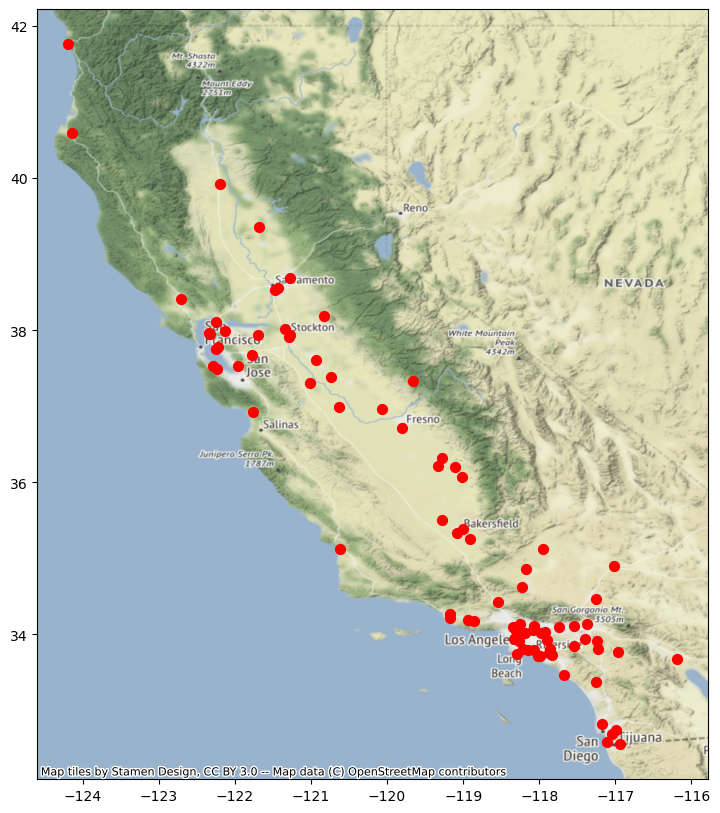

In [228]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(potential_sites['longitude'], potential_sites['latitude']))

# Set the CRS for the GeoDataFrame
gdf.crs = 'EPSG:4326'  # Assuming WGS84 coordinate system

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points
gdf.plot(ax=ax, color='red', markersize=50)

# Add the satellite basemap using contextily
ctx.add_basemap(ax, crs=gdf.crs)

plt.show()

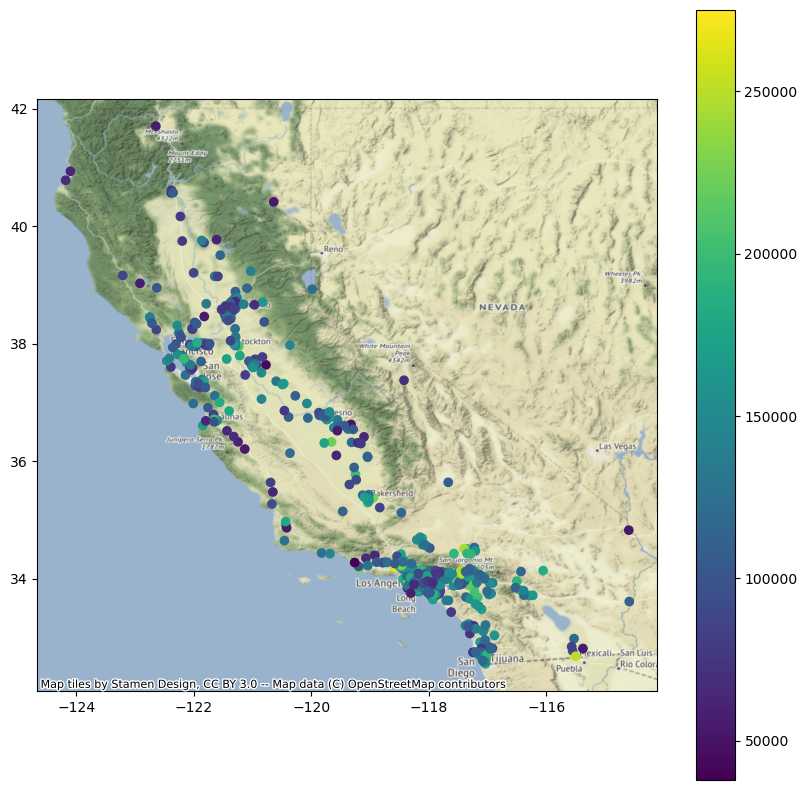

In [230]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(stores['longitude'], stores['latitude']))
gdf['Sales'] = stores['Sales']

# Set the CRS for the GeoDataFrame
gdf.crs = 'EPSG:4326'  # Assuming WGS84 coordinate system

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points with color ramp based on sales
gdf.plot(ax=ax, column='Sales', cmap='viridis', legend=True)

# Add the satellite basemap using contextily
ctx.add_basemap(ax, crs=gdf.crs)

plt.show()

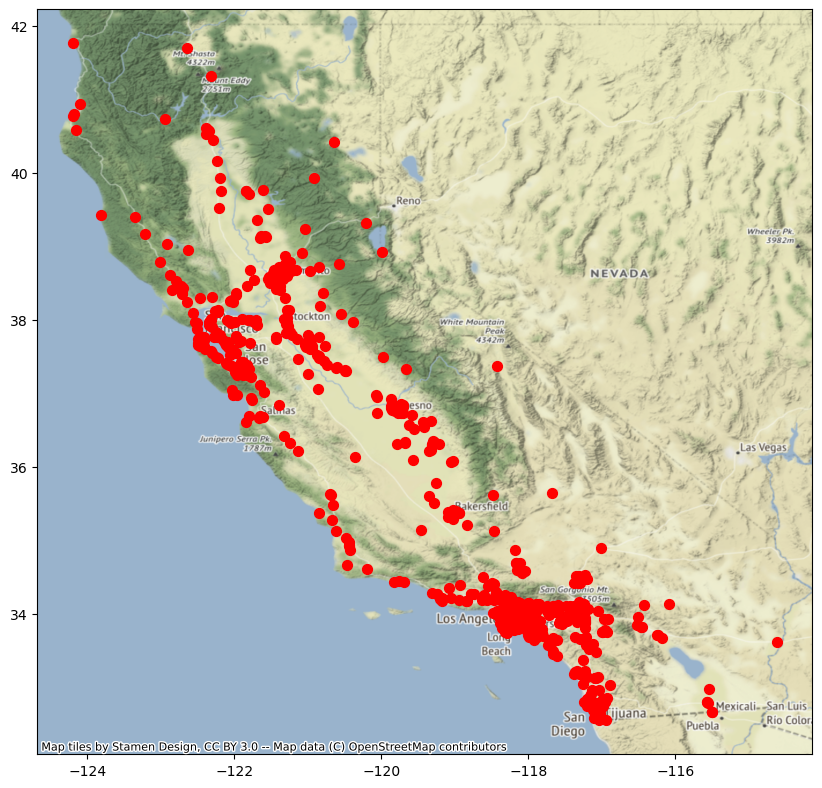

In [235]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(competition['longitude'], competition['latitude']))

# Set the CRS for the GeoDataFrame
gdf.crs = 'EPSG:4326'  # Assuming WGS84 coordinate system

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points
gdf.plot(ax=ax, color='red', markersize=50)

# Add the satellite basemap using contextily
ctx.add_basemap(ax, crs=gdf.crs)

plt.show()

Text(0, 0.5, 'Value')

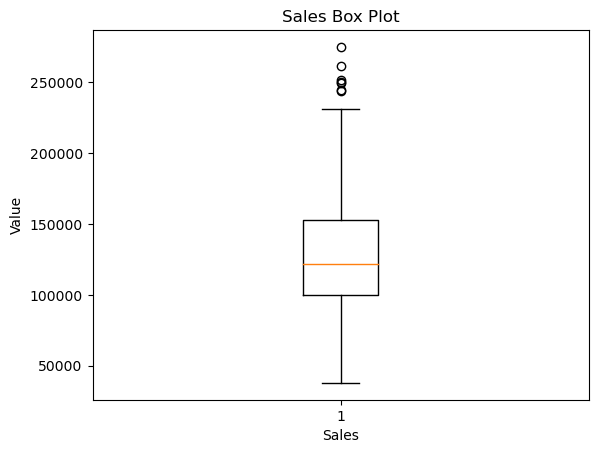

In [285]:
# Create the box plot
plt.boxplot(stores['Sales'])

# Set the title and labels
plt.title('Sales Box Plot')
plt.xlabel('Sales')
plt.ylabel('Value')

### Model Prep

In [39]:
stores = calculate_disToNextAZ(stores)
stores = calculate_disToComp(stores, competition)

In [40]:
potential_sites = calculate_disToNextAZ(potential_sites)
potential_sites = calculate_disToComp(potential_sites, competition)

In [41]:
#check if any existing stores are marked as potential sites
get_matching_records(stores, potential_sites, 'latitude', 'longitude')

,index,STORE,STORE_TYPE,Open Date,Sales,Location,latitude,longitude,city,state,months_since,Monthly Sales,disToNextAZ,disToComp


In [42]:
#check if any competitors stores are marked as potential sites
get_matching_records(competition, potential_sites, 'latitude', 'longitude')

,index,Location,latitude,longitude,city,state


In [43]:
model_df = pd.merge(stores, demographics, on="STORE", how="inner")

In [47]:
model_df = square_features(model_df)

In [78]:
# Apply one-hot encoding
one_hot_encoded = pd.get_dummies(model_df['STORE_TYPE'])

# Concatenate the original DataFrame with the one-hot encoded features
model_df = pd.concat([model_df, one_hot_encoded], axis=1)

# Drop the original feature column
model_df = model_df.drop('STORE_TYPE', axis=1)

# Apply one-hot encoding
one_hot_encoded = pd.get_dummies(model_df['Urban_Rural'])

# Concatenate the original DataFrame with the one-hot encoded features
model_df = pd.concat([model_df, one_hot_encoded], axis=1)

# Drop the original feature column
model_df = model_df.drop('Urban_Rural', axis=1)

In [184]:
potential_sites_model = find_closest_lat_lon(potential_sites, model_df, "latitude", "longitude")

In [45]:
model_df = model_df.dropna().reset_index()
potential_sites_model = potential_sites_model.dropna().reset_index()

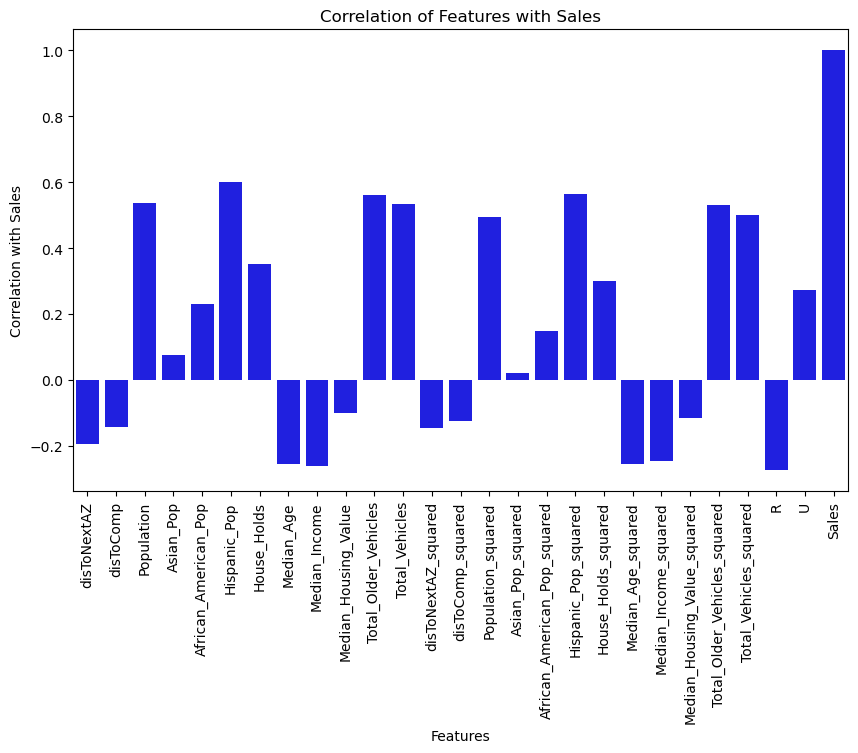

In [247]:
# Specify the feature column(s) you want to compare
features = ['disToNextAZ', 'disToComp',
       'Population', 'Asian_Pop', 'African_American_Pop', 'Hispanic_Pop',
       'House_Holds', 'Median_Age', 'Median_Income', 'Median_Housing_Value',
       'Total_Older_Vehicles', 'Total_Vehicles',
       'disToNextAZ_squared', 'disToComp_squared', 'Population_squared',
       'Asian_Pop_squared', 'African_American_Pop_squared',
       'Hispanic_Pop_squared', 'House_Holds_squared', 'Median_Age_squared',
       'Median_Income_squared', 'Median_Housing_Value_squared',
       'Total_Older_Vehicles_squared', 'Total_Vehicles_squared', 'R',
       'U']

subset_df = model_df[features + ['Sales']]

# Compute the correlation between each feature and the target variable
correlations = subset_df.corr()['Sales']

# Create a bar plot of the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, color='blue')

# Set the labels and title
plt.xlabel('Features')
plt.ylabel('Correlation with Sales')
plt.title('Correlation of Features with Sales')

# Rotate the x-axis labels if needed
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

In [254]:
correlations[(correlations > -0.2) & (correlations < 0.2)].index.tolist()

['disToNextAZ',
 'disToComp',
 'Asian_Pop',
 'Median_Housing_Value',
 'disToNextAZ_squared',
 'disToComp_squared',
 'Asian_Pop_squared',
 'African_American_Pop_squared',
 'Median_Housing_Value_squared']

### Model Design

#### Linear Regression

In [122]:
# Separate the features (X) and the target variable (y)
X = model_df[['disToNextAZ', 'disToComp',
       'Population', 'Asian_Pop', 'African_American_Pop', 'Hispanic_Pop',
       'House_Holds', 'Median_Age', 'Median_Income', 'Median_Housing_Value',
       'Total_Older_Vehicles', 'Total_Vehicles',
       'disToNextAZ_squared', 'disToComp_squared', 'Population_squared',
       'Asian_Pop_squared', 'African_American_Pop_squared',
       'Hispanic_Pop_squared', 'House_Holds_squared', 'Median_Age_squared',
       'Median_Income_squared', 'Median_Housing_Value_squared',
       'Total_Older_Vehicles_squared', 'Total_Vehicles_squared', 'R',
       'U']]
y = model_df['Sales']

# Split the dataset into training and testing sets for holdout validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform iterative backward selection on the training set
selected_features = list(X_train.columns)
num_features = len(selected_features)

while True:
    # Fit the model with the selected features on the training set
    X_temp = X_train[selected_features]
    X_temp = sm.add_constant(X_temp)  # Add a constant term for intercept
    model = sm.OLS(y_train, X_temp).fit()

    # Get the p-values for each feature
    p_values = model.pvalues[1:]  # Exclude the constant term

    # Find the feature with the highest p-value
    max_p_value = p_values.max()
    max_p_index = selected_features.index(p_values.idxmax())
    eliminated_feature = selected_features[max_p_index]

    if max_p_value > 0.05:
        print(f'Eliminated feature: {eliminated_feature} (p-value: {max_p_value:.4f})')
        selected_features.remove(eliminated_feature)
    else:
        print('No more features to eliminate.')
        break

print('Selected features:', selected_features)

# Fit the final model on the training set with the selected features
X_train_final = X_train[selected_features]
X_train_final = sm.add_constant(X_train_final)  # Add a constant term for intercept
final_model = sm.OLS(y_train, X_train_final).fit()

# Evaluate the final model on the testing set
X_test_final = X_test[selected_features]
X_test_final = sm.add_constant(X_test_final)
y_pred = final_model.predict(X_test_final)
mse = mean_squared_error(y_test, y_pred)

print('Final Model Summary:')
print(final_model.summary())
print('Best MSE:', mse)

Eliminated feature: Hispanic_Pop (p-value: 0.9640)
Eliminated feature: Median_Age (p-value: 0.8428)
Eliminated feature: Median_Housing_Value (p-value: 0.6952)
Eliminated feature: Asian_Pop_squared (p-value: 0.5542)
Eliminated feature: R (p-value: 0.4270)
Eliminated feature: disToNextAZ_squared (p-value: 0.4164)
Eliminated feature: Hispanic_Pop_squared (p-value: 0.3555)
Eliminated feature: Median_Income_squared (p-value: 0.3462)
Eliminated feature: African_American_Pop (p-value: 0.2399)
Eliminated feature: Median_Age_squared (p-value: 0.2949)
Eliminated feature: Population_squared (p-value: 0.2882)
Eliminated feature: African_American_Pop_squared (p-value: 0.2593)
Eliminated feature: House_Holds_squared (p-value: 0.2121)
Eliminated feature: Total_Older_Vehicles_squared (p-value: 0.3693)
Eliminated feature: disToNextAZ (p-value: 0.1197)
Eliminated feature: Total_Vehicles_squared (p-value: 0.0695)
No more features to eliminate.
Selected features: ['disToComp', 'Population', 'Asian_Pop', '

In [197]:
coef_table = pd.DataFrame({
    'Coefficient': final_model.params,
    'Std. Error': final_model.bse,
    't-value': final_model.tvalues,
    'p-value': final_model.pvalues
})

In [198]:
coef_table

,Coefficient,Std. Error,t-value,p-value
const,8.328804e+04,7.470737e+03,11.148570,3.857948e-25
disToComp,2.870266e+03,9.902732e+02,2.898459,3.969239e-03
Population,1.660369e+00,4.257684e-01,3.899699,1.140118e-04
Asian_Pop,-1.590888e+00,4.496927e-01,-3.537724,4.539403e-04
House_Holds,-4.361828e+00,8.722015e-01,-5.000940,8.760671e-07
Median_Income,-7.753662e-01,9.775114e-02,-7.932042,2.477830e-14
Total_Older_Vehicles,-2.773653e+00,1.329394e+00,-2.086404,3.761362e-02
Total_Vehicles,4.120941e+00,1.193969e+00,3.451465,6.207255e-04
disToComp_squared,-3.783093e+01,1.198766e+01,-3.155823,1.729114e-03
Median_Housing_Value_squared,3.406704e-08,1.131327e-08,3.011247,2.777088e-03


In [137]:
# Generate the formula from the final model
intercept = final_model.params[0]
coefficients = final_model.params[1:]
feature_names = selected_features

formula = f'y = {intercept:.4f}'
for feature, coefficient in zip(feature_names, coefficients):
    formula += f' + {coefficient:.4f} * {feature}'

print('Formula:', formula)

Formula: y = 83288.0398 + 2870.2659 * disToComp + 1.6604 * Population + -1.5909 * Asian_Pop + -4.3618 * House_Holds + -0.7754 * Median_Income + -2.7737 * Total_Older_Vehicles + 4.1209 * Total_Vehicles + -37.8309 * disToComp_squared + 0.0000 * Median_Housing_Value_squared + 25169.6733 * U


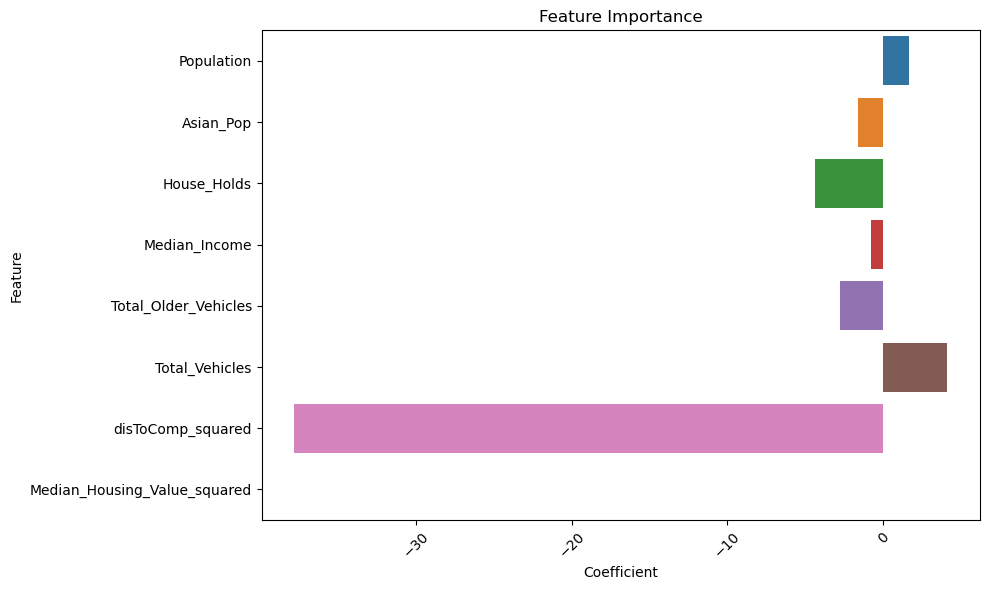

In [93]:
# Plotting feature importance
feature_importance = pd.Series(final_model.params[1:], index=selected_features)

# List of features to remove
features_to_remove = ['U','disToComp']

# Remove the features from the series
feature_importance = feature_importance.drop(features_to_remove)

# Set the figure size and orientation
plt.figure(figsize=(10, 6))  # Adjust the values as needed

# Create the bar plot
sns.barplot(x=feature_importance.values, y=feature_importance.index)

# Set plot title, labels, and rotation
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.xticks(rotation=45)  # Adjust the rotation angle as needed

# Show the plot
plt.tight_layout()  # Ensures all labels and ticks are visible
plt.show()

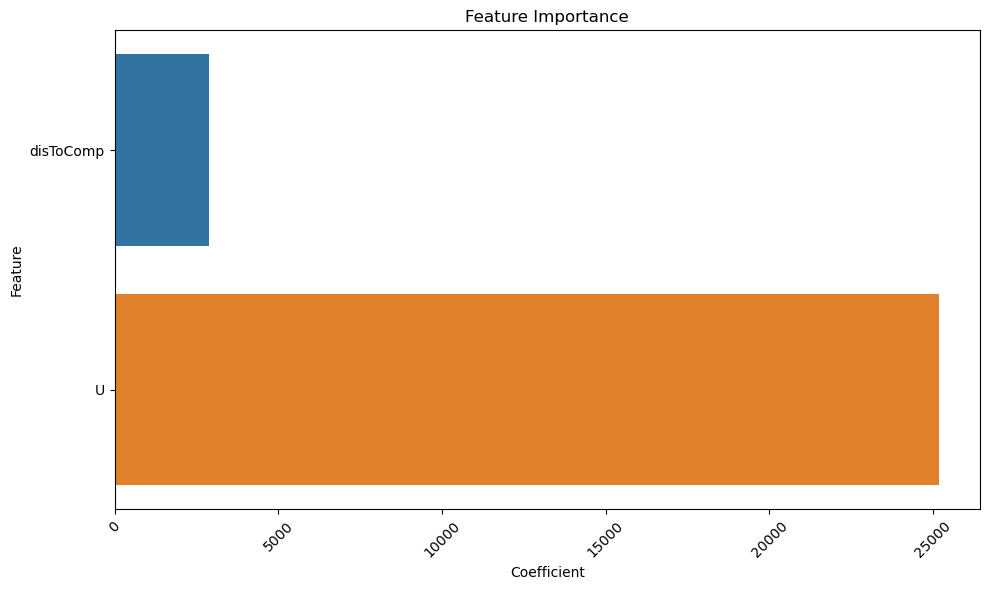

In [92]:
# Plotting feature importance
feature_importance = pd.Series(final_model.params[1:], index=selected_features)

# List of features to remove
features_to_remove = ['Population','Asian_Pop','House_Holds','Median_Income','Total_Older_Vehicles','Total_Vehicles','disToComp_squared','Median_Housing_Value_squared']

# Remove the features from the series
feature_importance = feature_importance.drop(features_to_remove)

# Set the figure size and orientation
plt.figure(figsize=(10, 6))  # Adjust the values as needed

# Create the bar plot
sns.barplot(x=feature_importance.values, y=feature_importance.index)

# Set plot title, labels, and rotation
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.xticks(rotation=45)  # Adjust the rotation angle as needed

# Show the plot
plt.tight_layout()  # Ensures all labels and ticks are visible
plt.show()

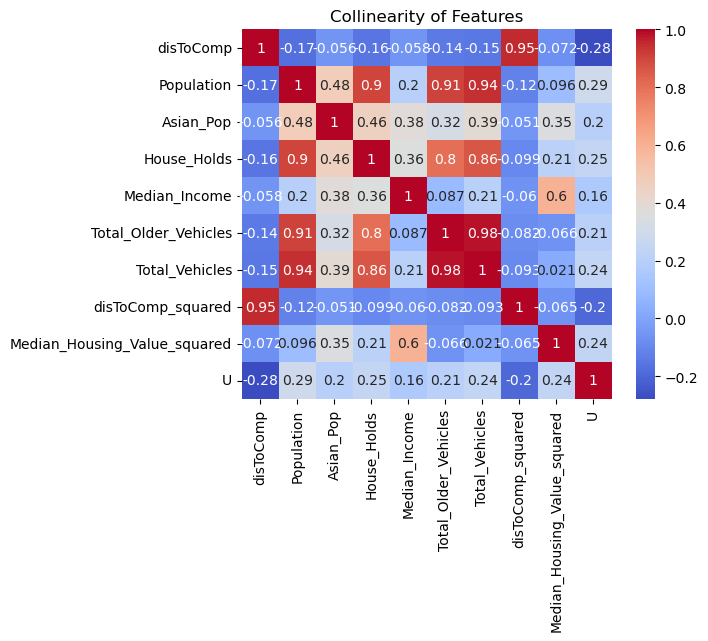

In [82]:
# Plotting collinearity of features
corr_matrix = X[selected_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Collinearity of Features')
plt.show()

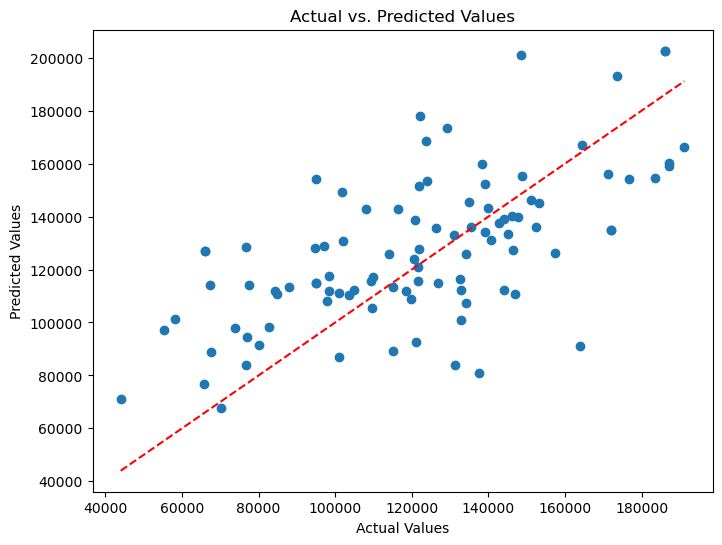

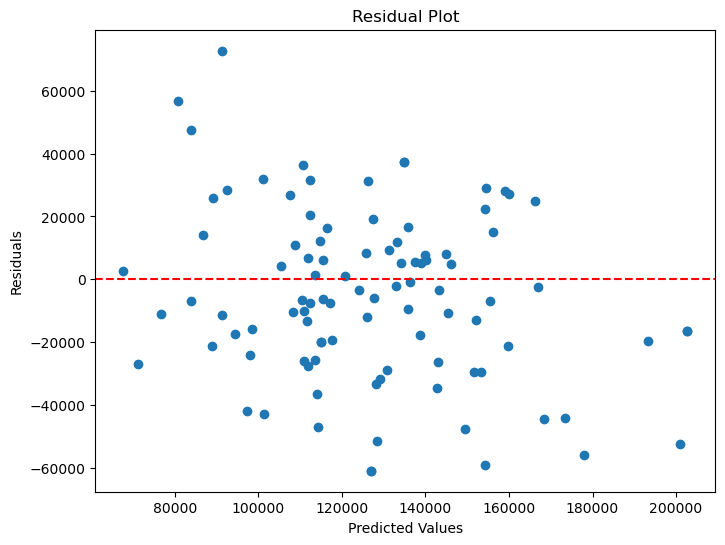

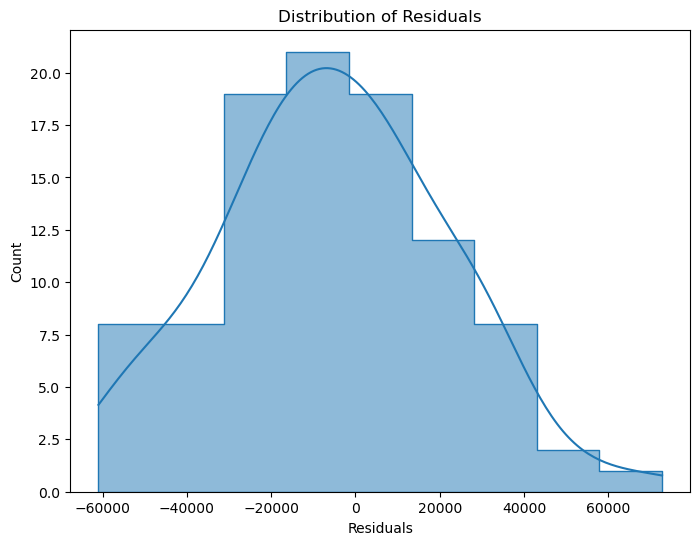

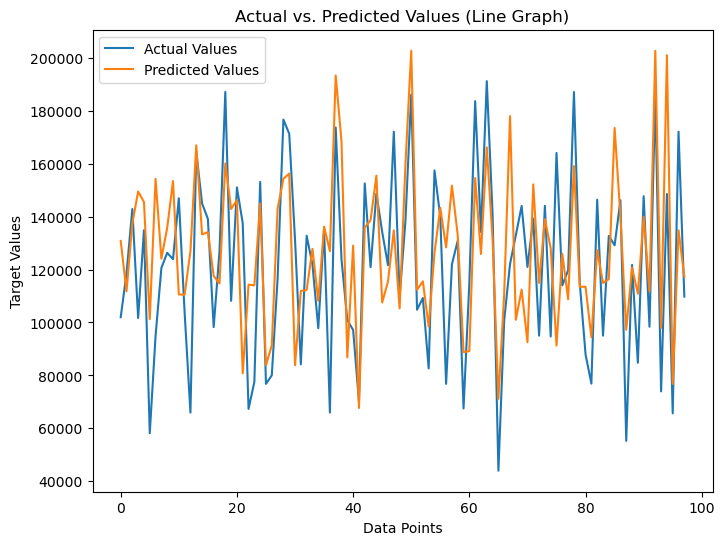

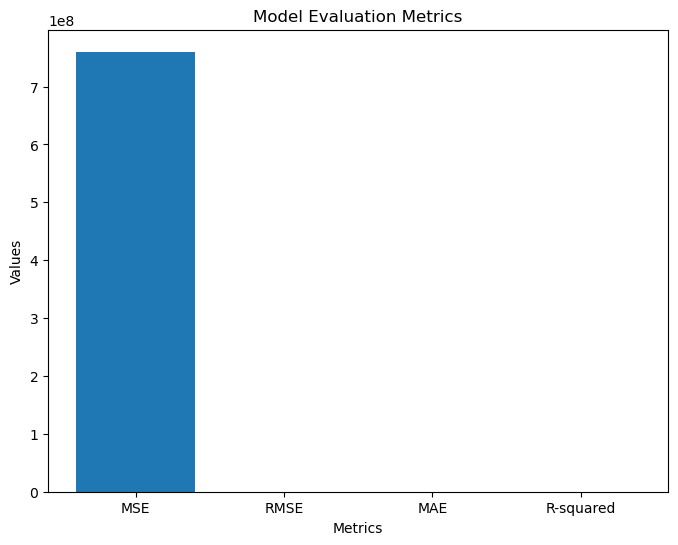

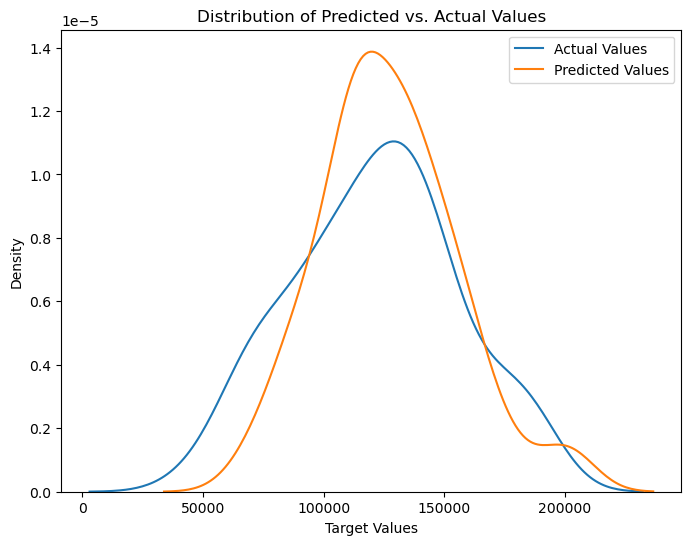

In [136]:
plot_regression_performance(y_test, y_pred)

#### Random Forest

In [98]:
# Separate the features (X) and the target variable (y)
X = model_df[['disToNextAZ', 'disToComp',
       'Population', 'Asian_Pop', 'African_American_Pop', 'Hispanic_Pop',
       'House_Holds', 'Median_Age', 'Median_Income', 'Median_Housing_Value',
       'Total_Older_Vehicles', 'Total_Vehicles',
       'disToNextAZ_squared', 'disToComp_squared', 'Population_squared',
       'Asian_Pop_squared', 'African_American_Pop_squared',
       'Hispanic_Pop_squared', 'House_Holds_squared', 'Median_Age_squared',
       'Median_Income_squared', 'Median_Housing_Value_squared',
       'Total_Older_Vehicles_squared', 'Total_Vehicles_squared', 'R',
       'U']]
y = model_df['Sales']

# Split the dataset into training and testing sets for holdout validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform iterative backward selection
selected_features = list(X_train.columns)
best_model = None
best_mse = float('inf')
threshold = 0.01  # Set the threshold for the decrease in MSE

while True:
    # Create a Random Forest model with the selected features
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[selected_features], y_train)

    # Calculate the Mean Squared Error on the testing set
    y_pred = model.predict(X_test[selected_features])
    mse = mean_squared_error(y_test, y_pred)

    if mse < best_mse:
        best_mse = mse
        best_model = model

    # Calculate the decrease in MSE for each feature
    mse_decrease = {}
    for feature in selected_features:
        reduced_features = selected_features.copy()
        reduced_features.remove(feature)
        model_reduced = RandomForestRegressor(random_state=42)
        model_reduced.fit(X_train[reduced_features], y_train)
        y_pred_reduced = model_reduced.predict(X_test[reduced_features])
        mse_reduced = mean_squared_error(y_test, y_pred_reduced)
        mse_decrease[feature] = mse - mse_reduced

    # Find the feature with the lowest decrease in MSE
    eliminated_feature = min(mse_decrease, key=mse_decrease.get)
    decrease_mse = mse_decrease[eliminated_feature]

    if decrease_mse < threshold:
        print(f'Eliminated feature: {eliminated_feature} (MSE decrease: {decrease_mse:.4f})')
        selected_features.remove(eliminated_feature)
    else:
        print('No more features to eliminate.')
        break

print('Selected features:', selected_features)
print('Best MSE:', best_mse)
print('Best Model:', best_model)

Eliminated feature: disToNextAZ (MSE decrease: -3632773.3901)
Eliminated feature: Total_Older_Vehicles_squared (MSE decrease: -13209453.7277)
Eliminated feature: Total_Older_Vehicles (MSE decrease: -3967985.2999)
Eliminated feature: disToNextAZ_squared (MSE decrease: -17707528.2679)
Eliminated feature: Median_Income_squared (MSE decrease: -2704988.0935)
Eliminated feature: R (MSE decrease: -6135830.6361)
No more features to eliminate.
Selected features: ['disToComp', 'Population', 'Asian_Pop', 'African_American_Pop', 'Hispanic_Pop', 'House_Holds', 'Median_Age', 'Median_Income', 'Median_Housing_Value', 'Total_Vehicles', 'disToComp_squared', 'Population_squared', 'Asian_Pop_squared', 'African_American_Pop_squared', 'Hispanic_Pop_squared', 'House_Holds_squared', 'Median_Age_squared', 'Median_Housing_Value_squared', 'Total_Vehicles_squared', 'U']
Best MSE: 714989105.2940027
Best Model: RandomForestRegressor(random_state=42)


C:\Users\ryanp\AppData\Local\Temp\ipykernel_3336\4040122809.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_selected["R"] = X_test["R"]


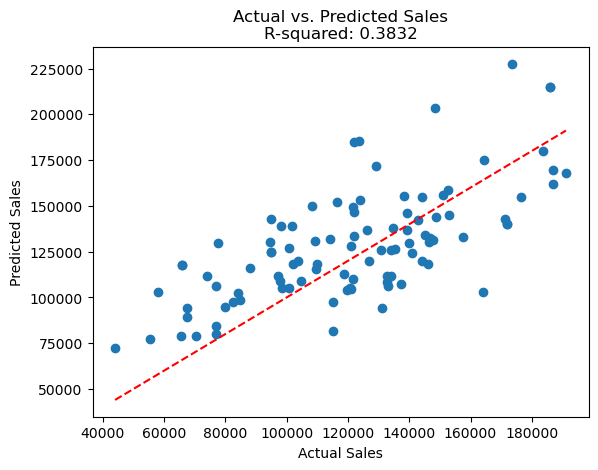

In [108]:
# Get the selected features
selected_features = ['disToNextAZ', 'disToComp', 'Population', 'Asian_Pop', 'African_American_Pop',
                     'Hispanic_Pop', 'House_Holds', 'Median_Age', 'Median_Income', 'Median_Housing_Value',
                     'Total_Older_Vehicles', 'Total_Vehicles', 'disToNextAZ_squared', 'disToComp_squared',
                     'Population_squared', 'Asian_Pop_squared', 'African_American_Pop_squared',
                     'Hispanic_Pop_squared', 'House_Holds_squared', 'Median_Age_squared', 'Median_Income_squared',
                     'Median_Housing_Value_squared', 'Total_Older_Vehicles_squared', 'Total_Vehicles_squared']

# Update X_test with only the selected features
X_test_selected = X_test[selected_features]

# Ensure the missing features "R" and "U" are present in X_test_selected
X_test_selected["R"] = X_test["R"]
X_test_selected["U"] = X_test["U"]

# Get the predicted values
y_pred = pd.Series(best_model.predict(X_test_selected))
y_test = pd.Series(y_test)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)

# Plot the scatter plot of predicted versus actual values
plt.scatter(y_test, y_pred)
# Add a diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales\nR-squared: {:.4f}'.format(r_squared))
plt.show()

#### Regression with Bagging and Boosting

C:\Users\ryanp\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging MSE: 846467275.6365073
Bagging R-squared: 0.26978916650957907


C:\Users\ryanp\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting MSE: 1005958895.1200309
Boosting R-squared: 0.13220262093376112


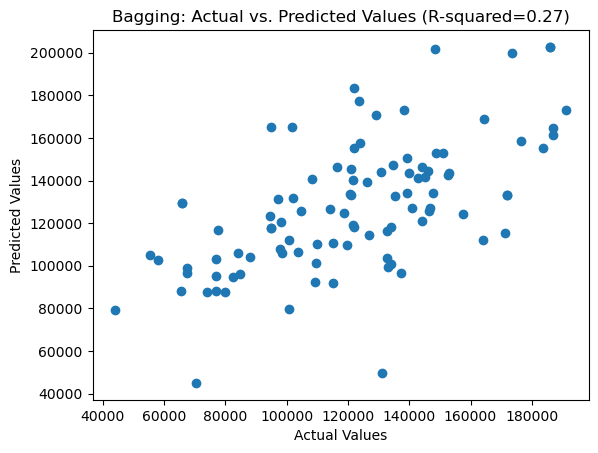

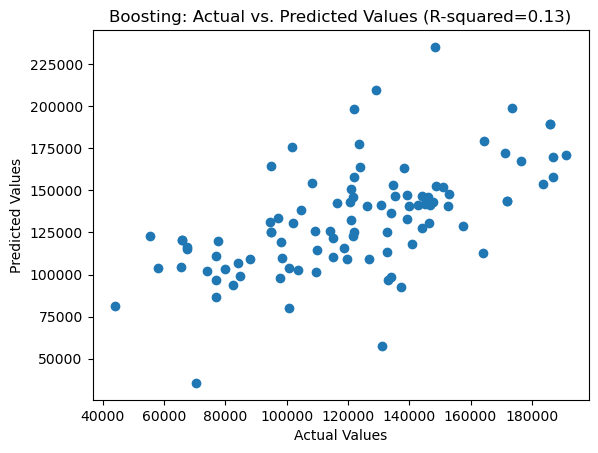

In [120]:
# Separate the features (X) and the target variable (y)
X = model_df[['disToNextAZ', 'disToComp', 'Population', 'Asian_Pop', 'African_American_Pop', 'Hispanic_Pop',
              'House_Holds', 'Median_Age', 'Median_Income', 'Median_Housing_Value',
              'Total_Older_Vehicles', 'Total_Vehicles', 'disToNextAZ_squared', 'disToComp_squared',
              'Population_squared', 'Asian_Pop_squared', 'African_American_Pop_squared',
              'Hispanic_Pop_squared', 'House_Holds_squared', 'Median_Age_squared',
              'Median_Income_squared', 'Median_Housing_Value_squared',
              'Total_Older_Vehicles_squared', 'Total_Vehicles_squared']]
y = model_df['Sales']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging with Linear Regression
bagging_model = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)
print('Bagging MSE:', mse_bagging)
print('Bagging R-squared:', r2_bagging)

# Boosting with Linear Regression
boosting_model = AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=42)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
mse_boosting = mean_squared_error(y_test, y_pred_boosting)
r2_boosting = r2_score(y_test, y_pred_boosting)
print('Boosting MSE:', mse_boosting)
print('Boosting R-squared:', r2_boosting)

# Plot the scatter plot of predicted versus actual values for Bagging
plt.scatter(y_test, y_pred_bagging)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Bagging: Actual vs. Predicted Values (R-squared={:.2f})'.format(r2_bagging))
plt.show()

# Plot the scatter plot of predicted versus actual values for Boosting
plt.scatter(y_test, y_pred_boosting)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Boosting: Actual vs. Predicted Values (R-squared={:.2f})'.format(r2_boosting))
plt.show()

### Applying Formula to Potential Sites

In [138]:
# Generate the formula from the final model
intercept = final_model.params[0]
coefficients = final_model.params[1:]
feature_names = selected_features

formula = f'y = {intercept:.4f}'
for feature, coefficient in zip(feature_names, coefficients):
    formula += f' + {coefficient:.4f} * {feature}'

print('Formula:', formula)

Formula: y = 83288.0398 + 2870.2659 * disToComp + 1.6604 * Population + -1.5909 * Asian_Pop + -4.3618 * House_Holds + -0.7754 * Median_Income + -2.7737 * Total_Older_Vehicles + 4.1209 * Total_Vehicles + -37.8309 * disToComp_squared + 0.0000 * Median_Housing_Value_squared + 25169.6733 * U


In [140]:
final_model.params[1:]

disToComp                       2.870266e+03
Population                      1.660369e+00
Asian_Pop                      -1.590888e+00
House_Holds                    -4.361828e+00
Median_Income                  -7.753662e-01
Total_Older_Vehicles           -2.773653e+00
Total_Vehicles                  4.120941e+00
disToComp_squared              -3.783093e+01
Median_Housing_Value_squared    3.406704e-08
U                               2.516967e+04
dtype: float64

In [186]:
potential_sites_model = potential_sites_model[['disToComp','Population','Asian_Pop','House_Holds','Median_Income','Total_Older_Vehicles','Total_Vehicles','disToComp_squared','Median_Housing_Value_squared','U']]
potential_sites_model = sm.add_constant(potential_sites_model)

# Calculate the predicted values using the formula
predicted_values = final_model.predict(potential_sites_model)

In [187]:
potential_sites['Predicted Sales'] = predicted_values

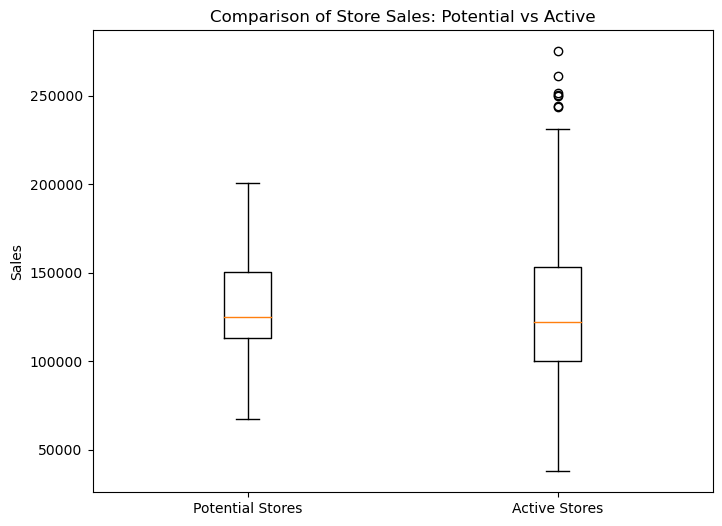

In [189]:
# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot([potential_sites['Predicted Sales'], stores['Sales']], labels=['Potential Stores', 'Active Stores'])
plt.title('Comparison of Store Sales: Potential vs Active')
plt.ylabel('Sales')
plt.show()

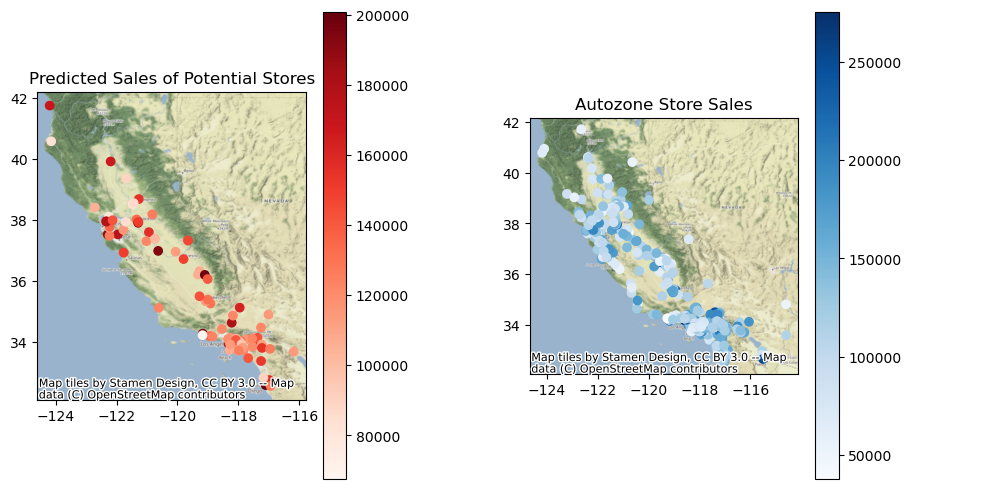

In [274]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(potential_sites['longitude'], potential_sites['latitude']))
gdf['Predicted Sales'] = potential_sites['Predicted Sales']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Set the CRS for the GeoDataFrame
gdf.crs = 'EPSG:4326'  # Assuming WGS84 coordinate system

# Plot the points with color ramp based on sales
gdf.plot(ax=axes[0], column='Predicted Sales', cmap='Reds', legend=True)
axes[0].set_title('Predicted Sales of Potential Stores')

# Add the satellite basemap using contextily
ctx.add_basemap(ax=axes[0], crs=gdf.crs)

gdf2 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(stores['longitude'], stores['latitude']))
gdf2['Sales'] = stores['Sales']

gdf2.plot(ax=axes[1], column='Sales', cmap='Blues', legend=True)
axes[1].set_title('Autozone Store Sales')
ctx.add_basemap(ax=axes[1], crs=gdf.crs)

plt.tight_layout()
plt.show()

In [286]:
potential_sites.to_csv('potential_sites_prediction.csv')